In [1]:
from autqec.automorphisms import *
from autqec.ZX_dualities import *
from autqec.utils.qec import *
from autqec.utils.qiskit import *
from autqec.utils.magma import *
import pickle

## [[72,12,6]] 

#### Define code

In [2]:
n = 72
k = 12
d = 6

H_X = np.load(f'./code_data/HX_n{n}k{k}d{d}.npy')
H_Z = np.load(f'./code_data/HZ_n{n}k{k}d{d}.npy')

zeros = np.zeros_like(H_X)
H_symp = np.array(np.vstack((np.hstack((H_X,zeros)),np.hstack((zeros,H_Z)))),dtype=int)

In [3]:
H_symp_rref, _, transform_rows, transform_cols = rref_mod2(H_symp)
H_symp_rref = H_symp_rref[~np.all(H_symp_rref == 0, axis=1)]
H_symp_rref_og_basis = H_symp_rref@inv_mod2(transform_cols)
assert H_symp_rref_og_basis.shape[0] == n-k
assert H_symp_rref_og_basis.shape[1] == 2*n

#### Standard form of code

In [4]:
G, LX, LZ, D = compute_standard_form(H_symp_rref_og_basis)

#### Logical basis in IBM paper

In [5]:
# unprimed block
X_unprimed = np.load(f'./code_data/n{n}k{k}d{d}_X_unprimed_mat.npy')
X_unprimed = np.array(np.hstack((X_unprimed, np.zeros_like(X_unprimed))),dtype=int)
Z_unprimed = np.load(f'./code_data/n{n}k{k}d{d}_Z_unprimed_mat.npy')
Z_unprimed = np.array(np.hstack((np.zeros_like(Z_unprimed),Z_unprimed)),dtype=int)

# primed block
X_primed = np.load(f'./code_data/n{n}k{k}d{d}_X_primed_mat.npy')
X_primed = np.array(np.hstack((X_primed, np.zeros_like(X_primed))),dtype=int)
Z_primed = np.load(f'./code_data/n{n}k{k}d{d}_Z_primed_mat.npy')
Z_primed = np.array(np.hstack((np.zeros_like(Z_primed),Z_primed)),dtype=int)

In [6]:
logicals_standard = np.vstack([LX,LZ])
logicals_ibm = np.vstack([X_unprimed,X_primed,Z_unprimed,Z_primed])
logicals_ibm_anticomm = np.vstack([Z_unprimed,Z_primed,X_unprimed,X_primed])

U_ibm_to_standard = symp_prod(logicals_standard,logicals_ibm_anticomm)

#### Automorphism group generators from MAGMA

In [7]:
#code_auts_dict = qec_code_ZX_dualities_from_magma_with_intersection(n,k,d,H_symp_rref_og_basis).run(fileroot='./')
filename = f'./ZX_dualities_n{n}k{k}d{d}.pkl'
with open(filename, 'rb') as f:
    code_auts_dict = pickle.load(f)
print('Aut Group Order: ', code_auts_dict['order'])
print('Time: ', code_auts_dict['time'])
print('No of aut gens: ', len(code_auts_dict['auts']))

Aut Group Order:  864
Time:  0.09
No of aut gens:  7


#### Circuits of automorphism group generators

In [8]:
auts = code_auts_dict['auts']
circuits = []
symp_mats = []
for num, aut in enumerate(auts):
    phys_act = circ_from_ZX_duality(H_symp_rref_og_basis,aut)        
    phys_circ, _ = phys_act.circ()
    log_act = logical_circ_and_pauli_correct(H_symp_rref_og_basis,phys_circ)
    symp_mat_standard = log_act.U_logical_act()
    symp_mat = inv_mod2(U_ibm_to_standard) @ symp_mat_standard @ U_ibm_to_standard %2
    circ = circ_from_symp_mat(symp_mat).run(), phys_circ
    circuits.append(circ)
    symp_mats.append(symp_mat)

In [9]:
filename = f'./symp_mats_n{n}k{k}d{d}.pkl'
with open(filename, 'wb') as f:
    pickle.dump(symp_mats, f)

### Logical action 1

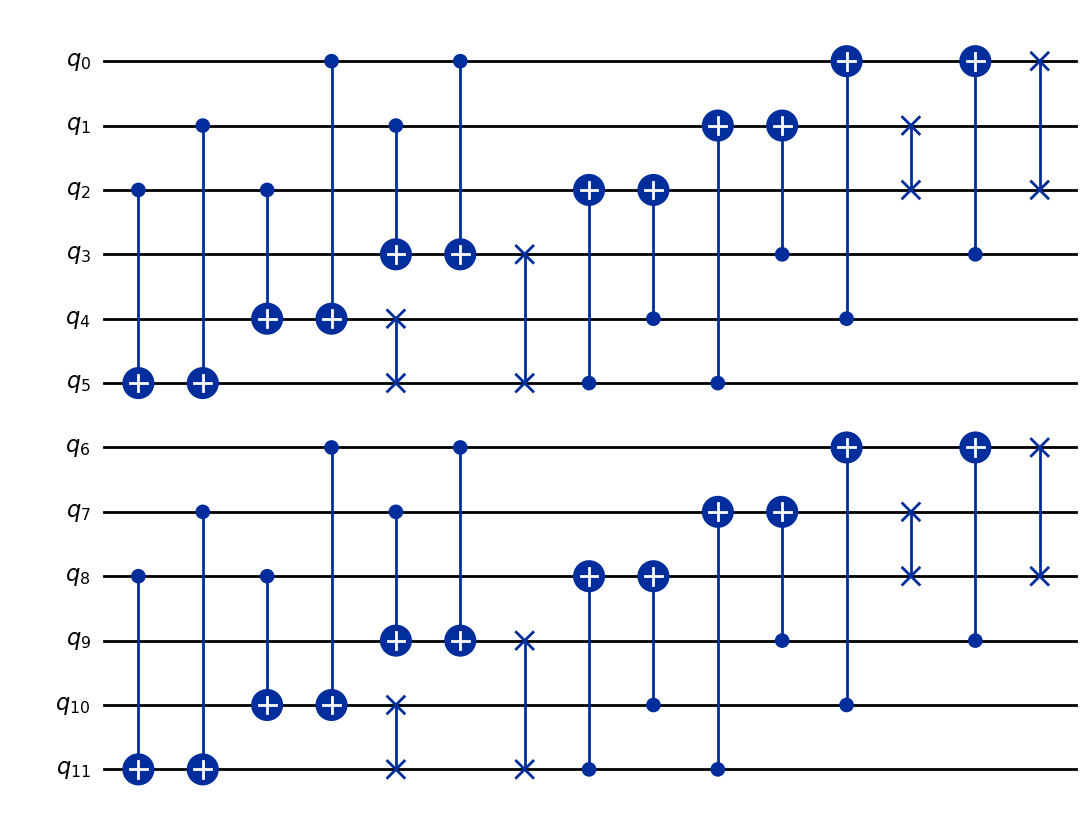

In [10]:
# logical circuit
log_act, phys_circ = circuits[0]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 2

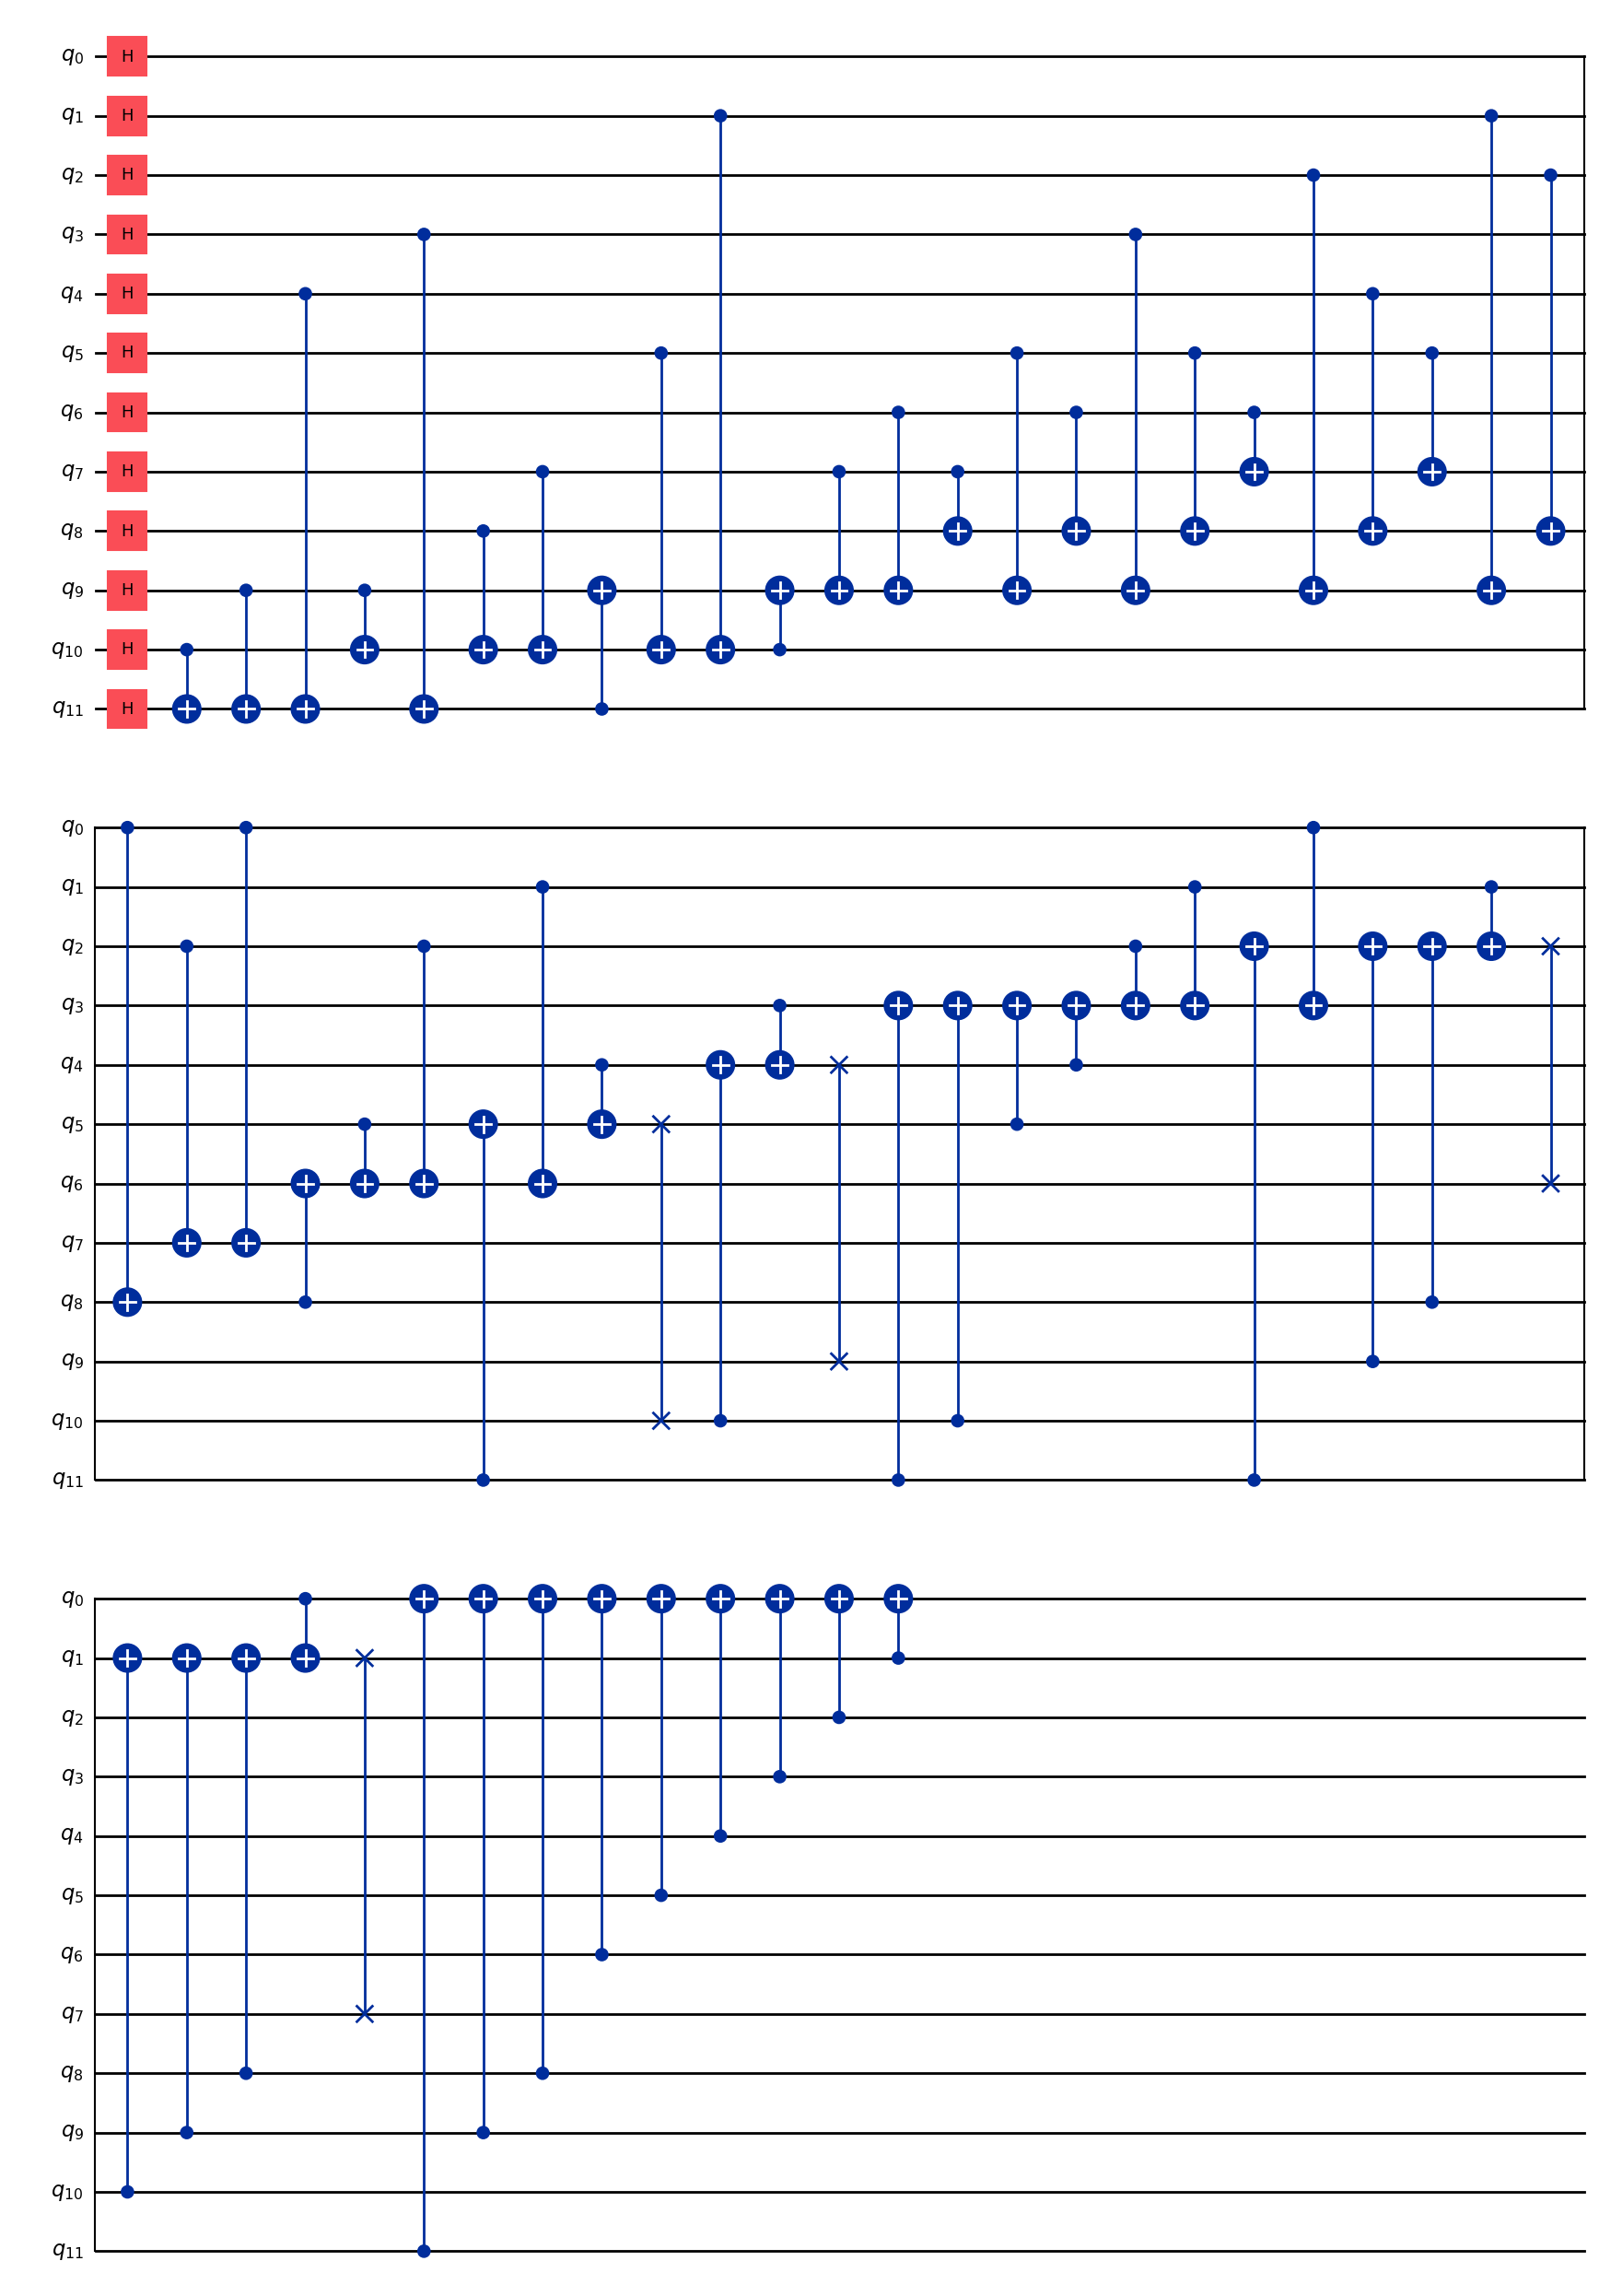

In [11]:
# logical circuit
log_act, phys_circ = circuits[1]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 3

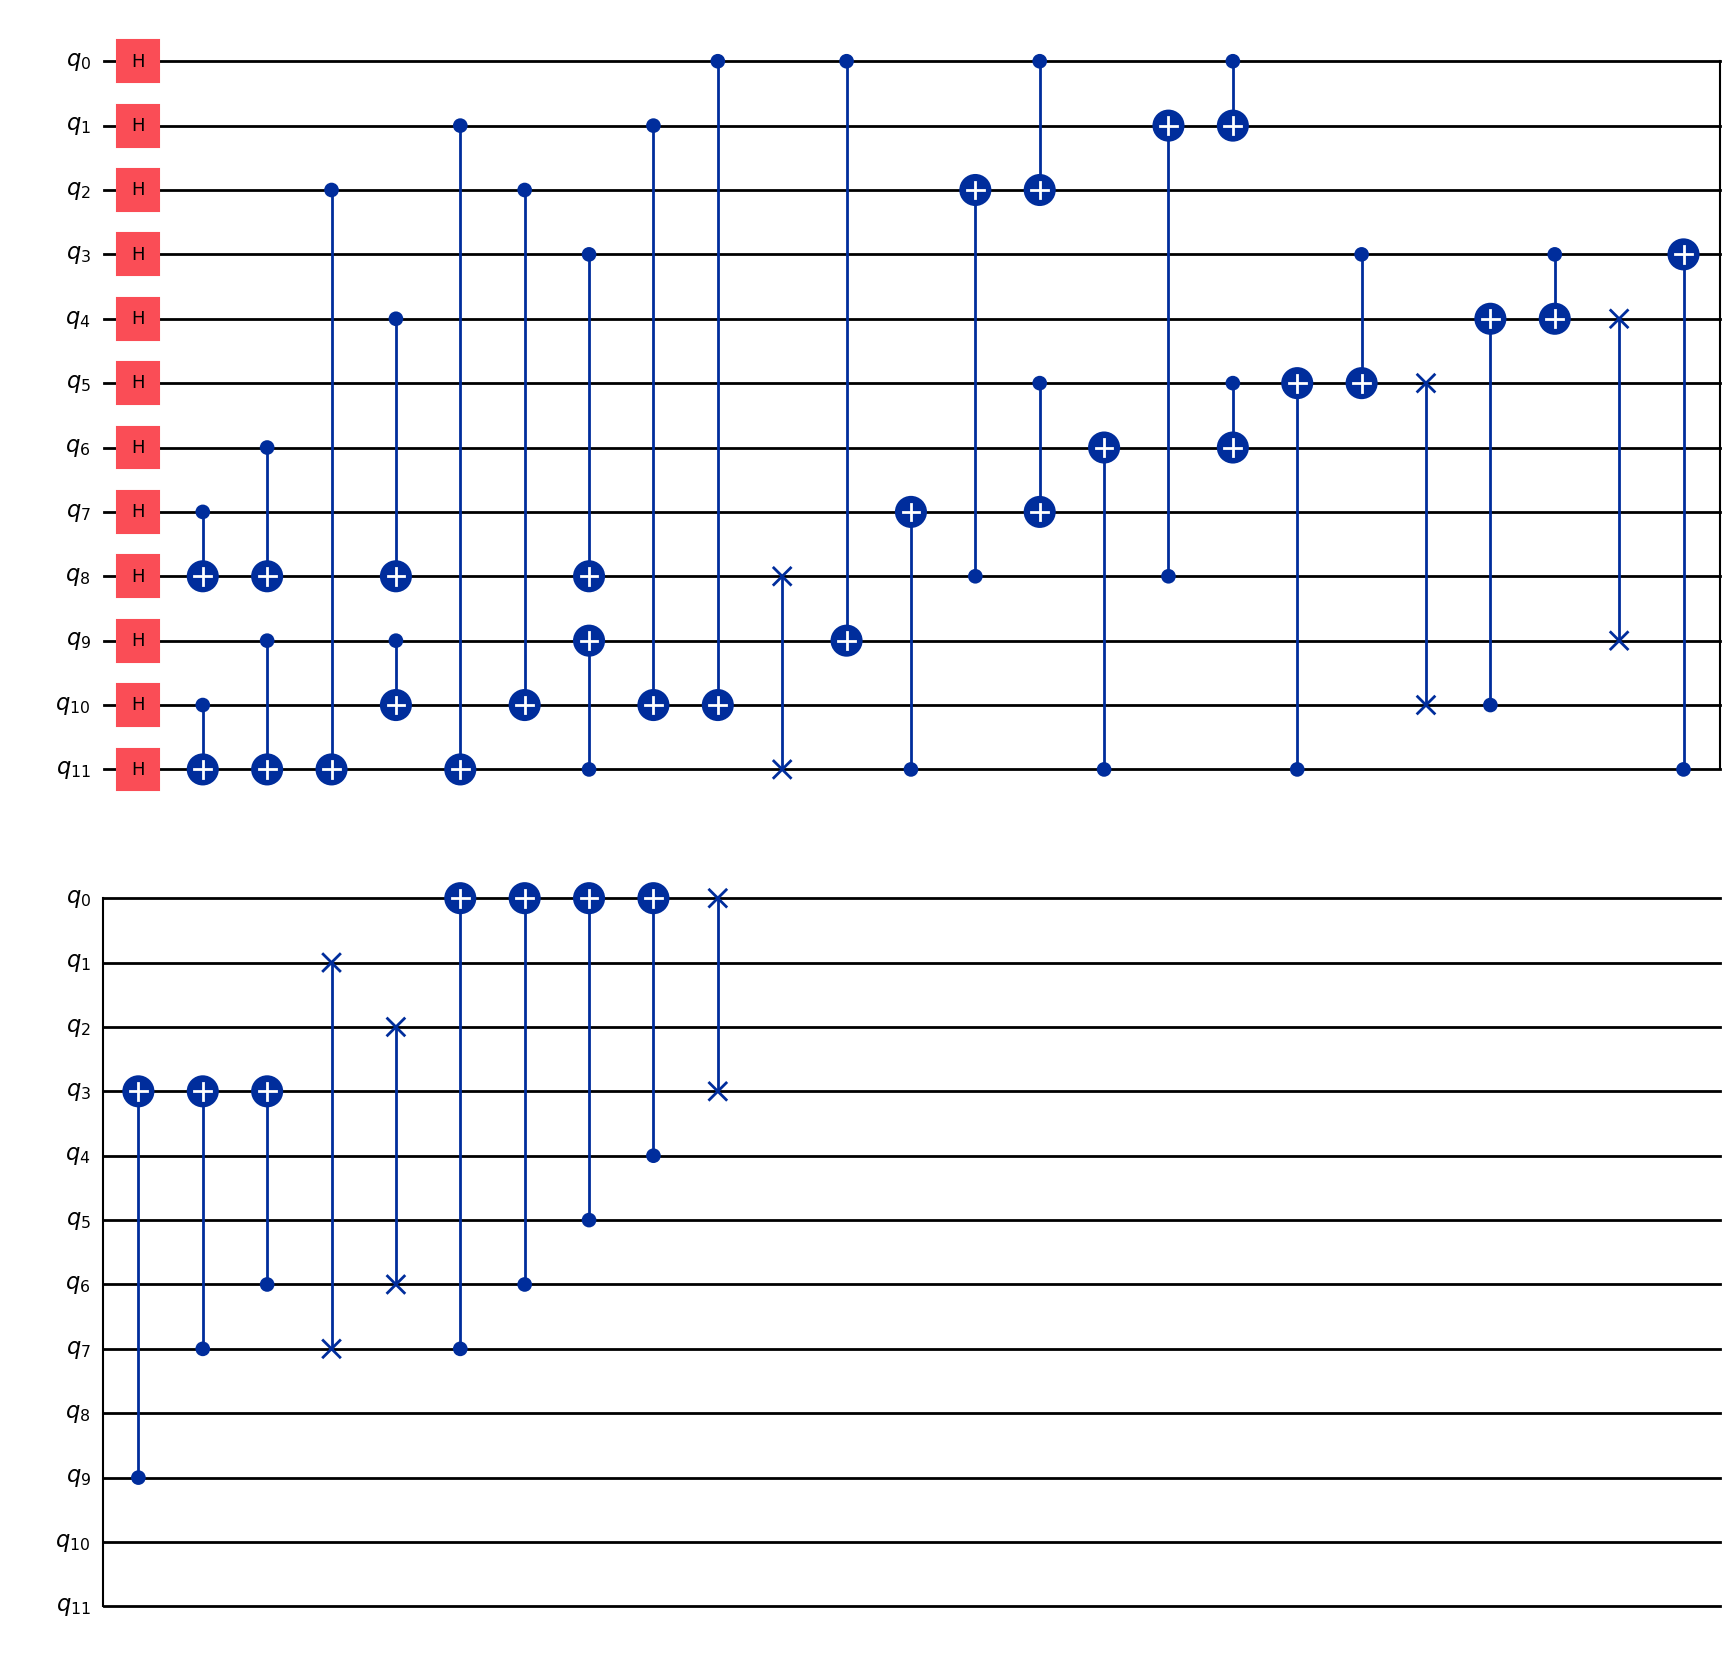

In [12]:
# logical circuit
log_act, phys_circ = circuits[2]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 4

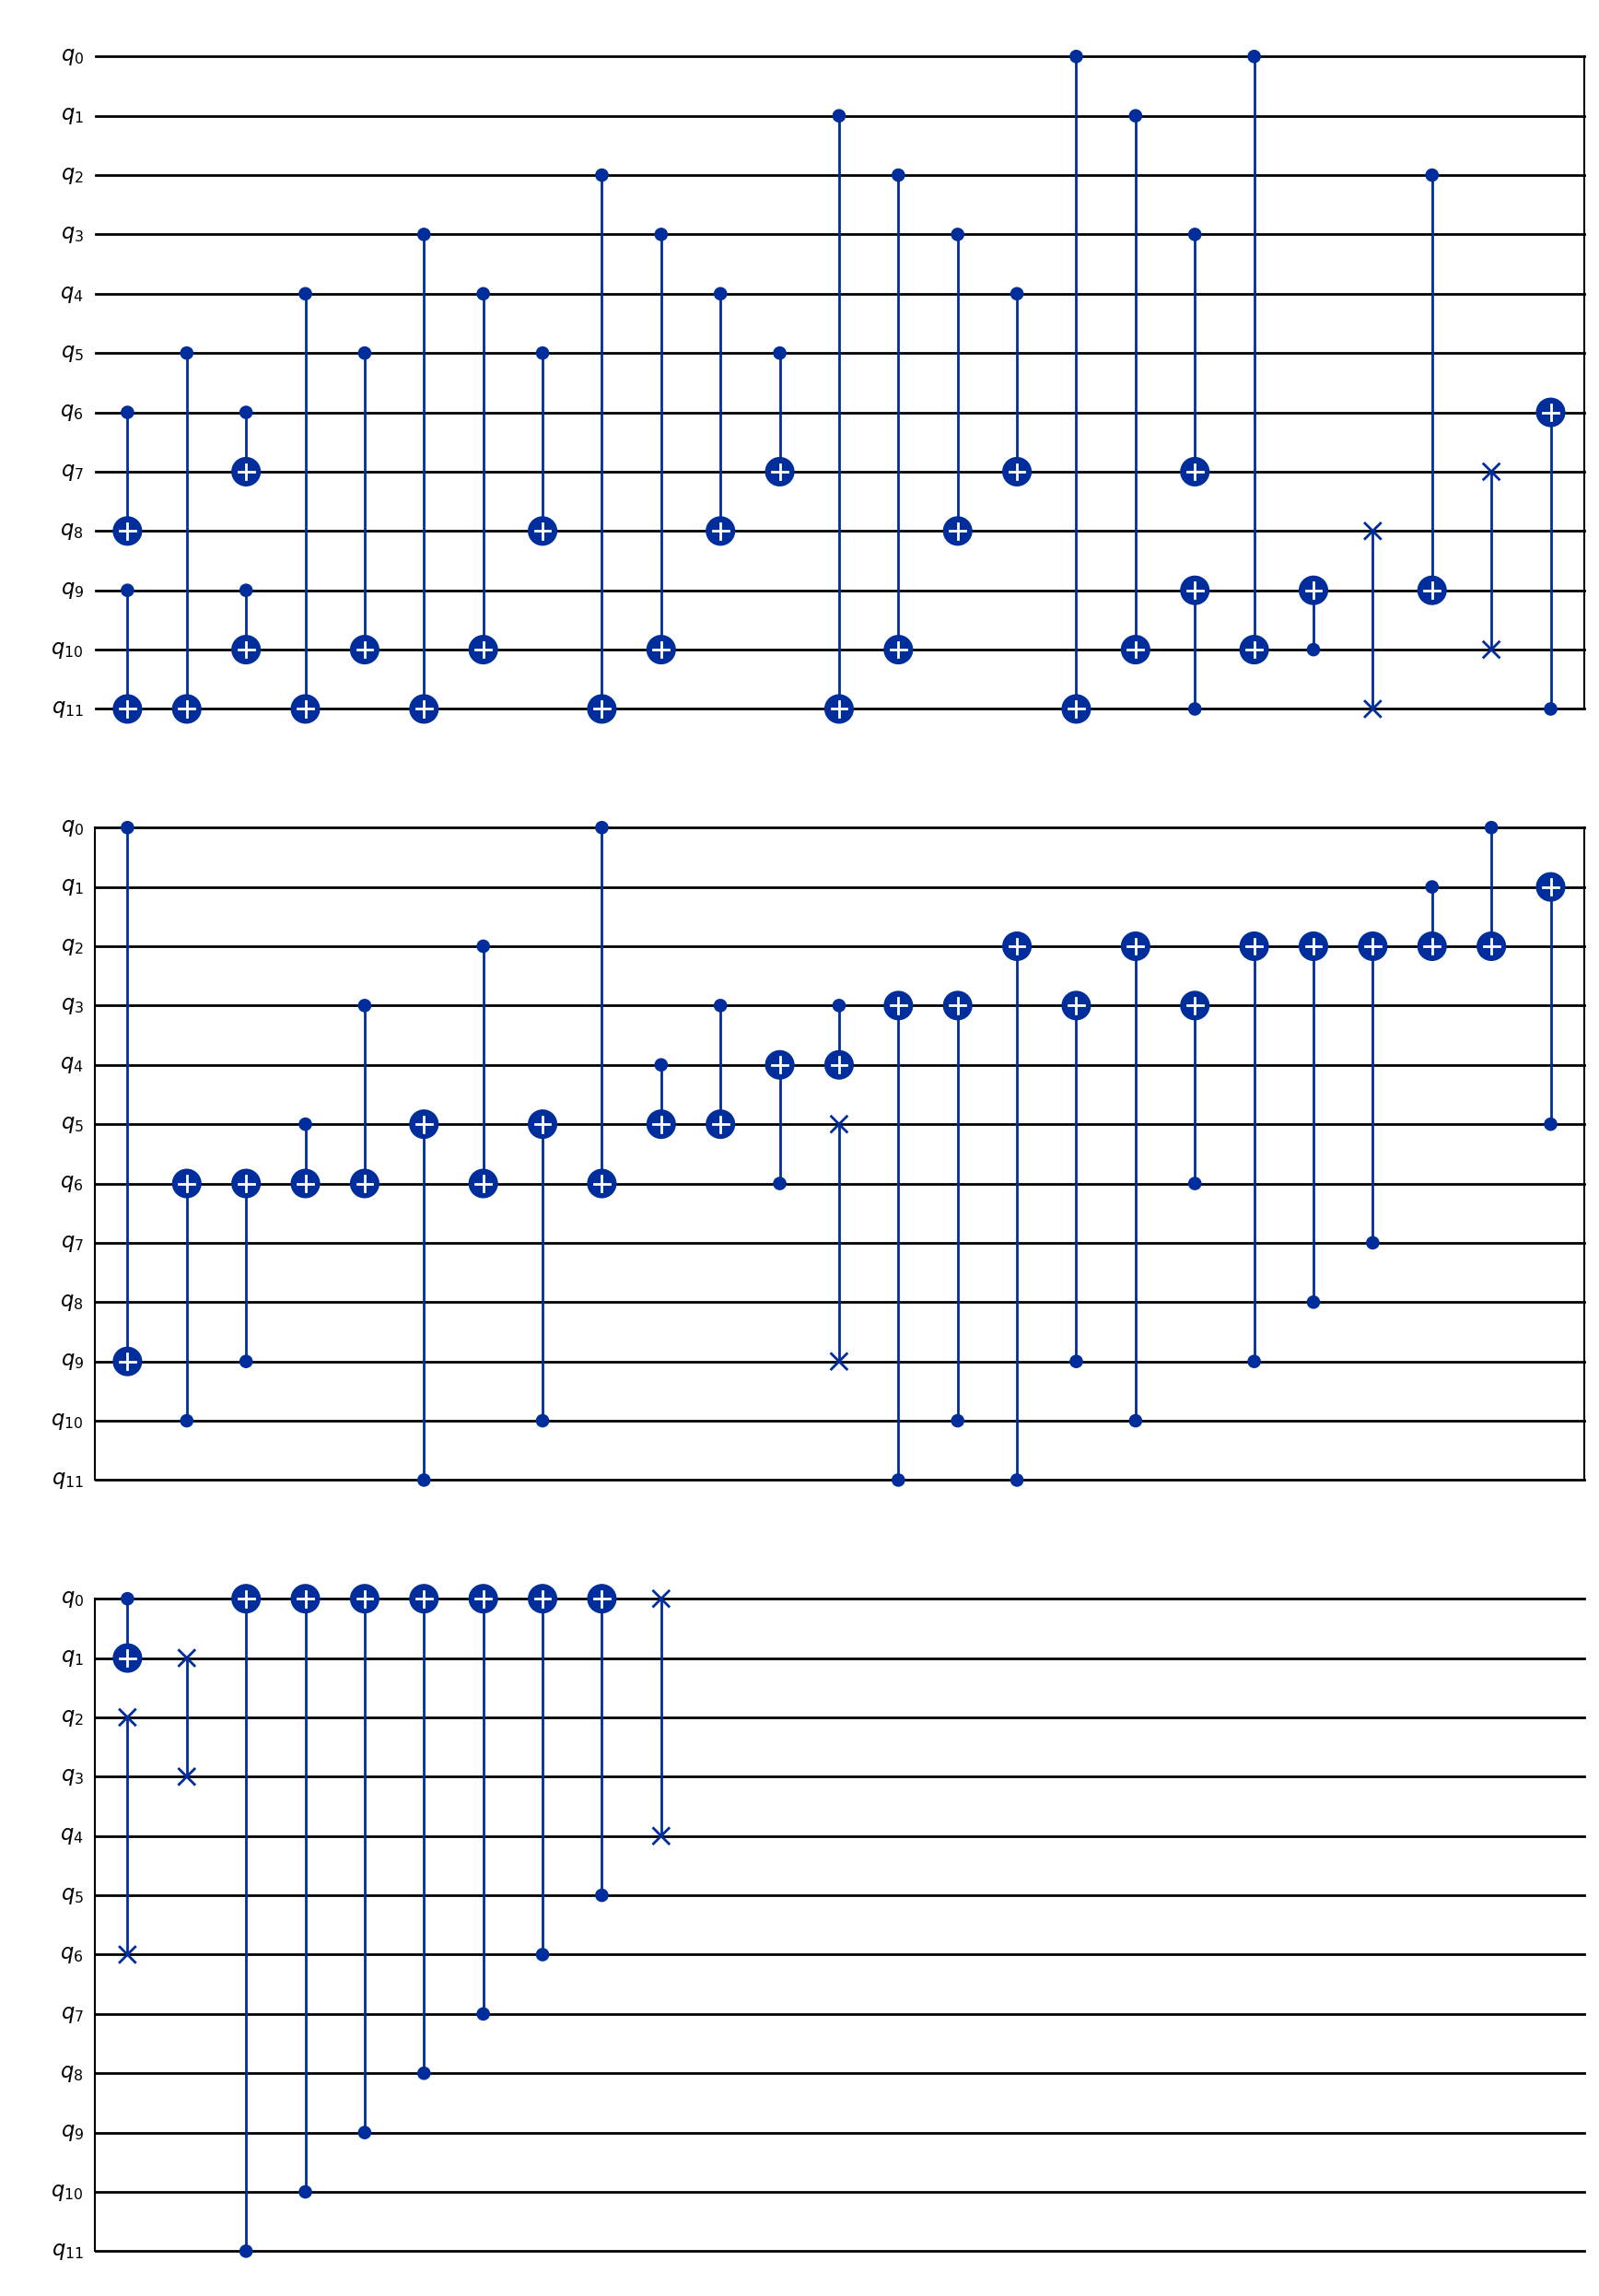

In [13]:
# logical circuit
log_act, phys_circ = circuits[3]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 5

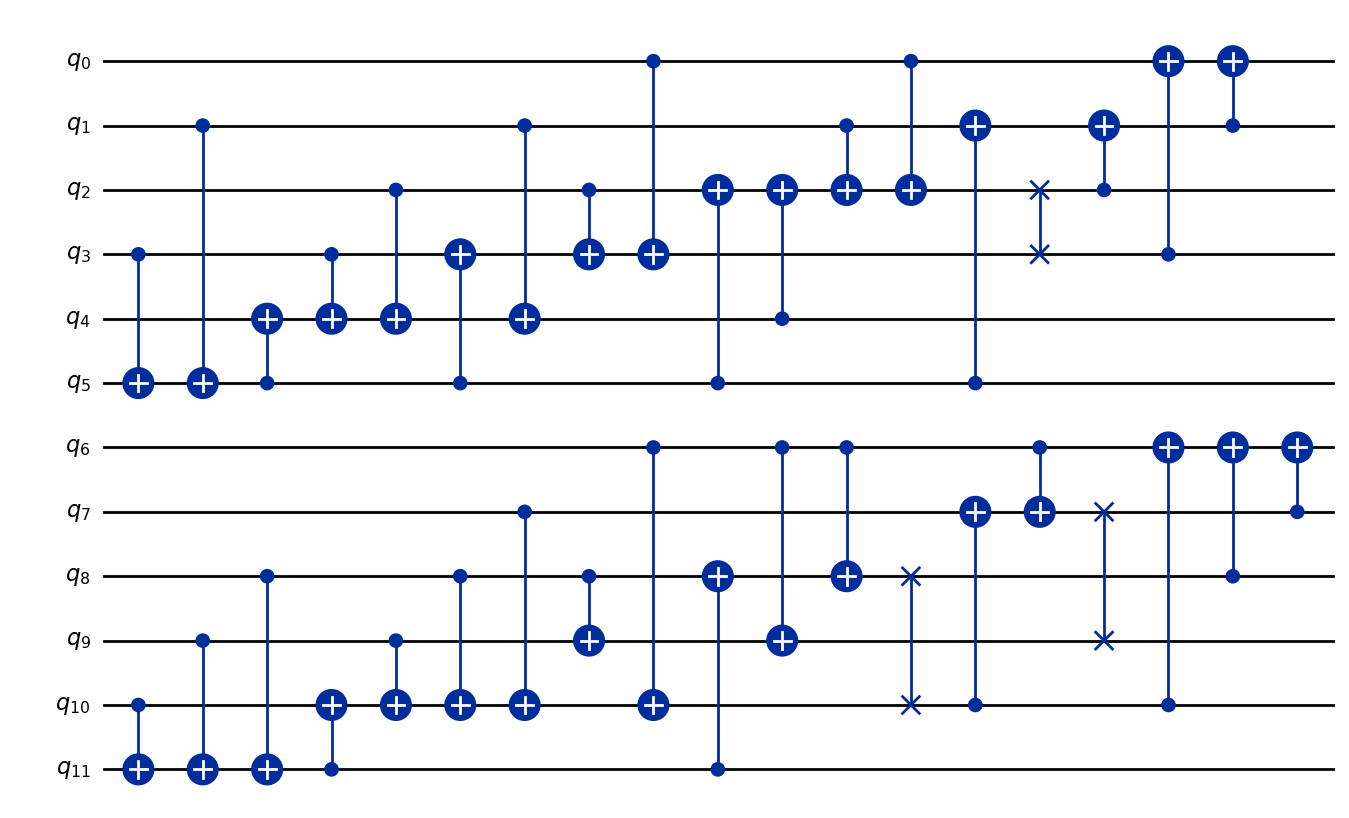

In [14]:
# logical circuit
log_act, phys_circ = circuits[4]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

## Logical action 6

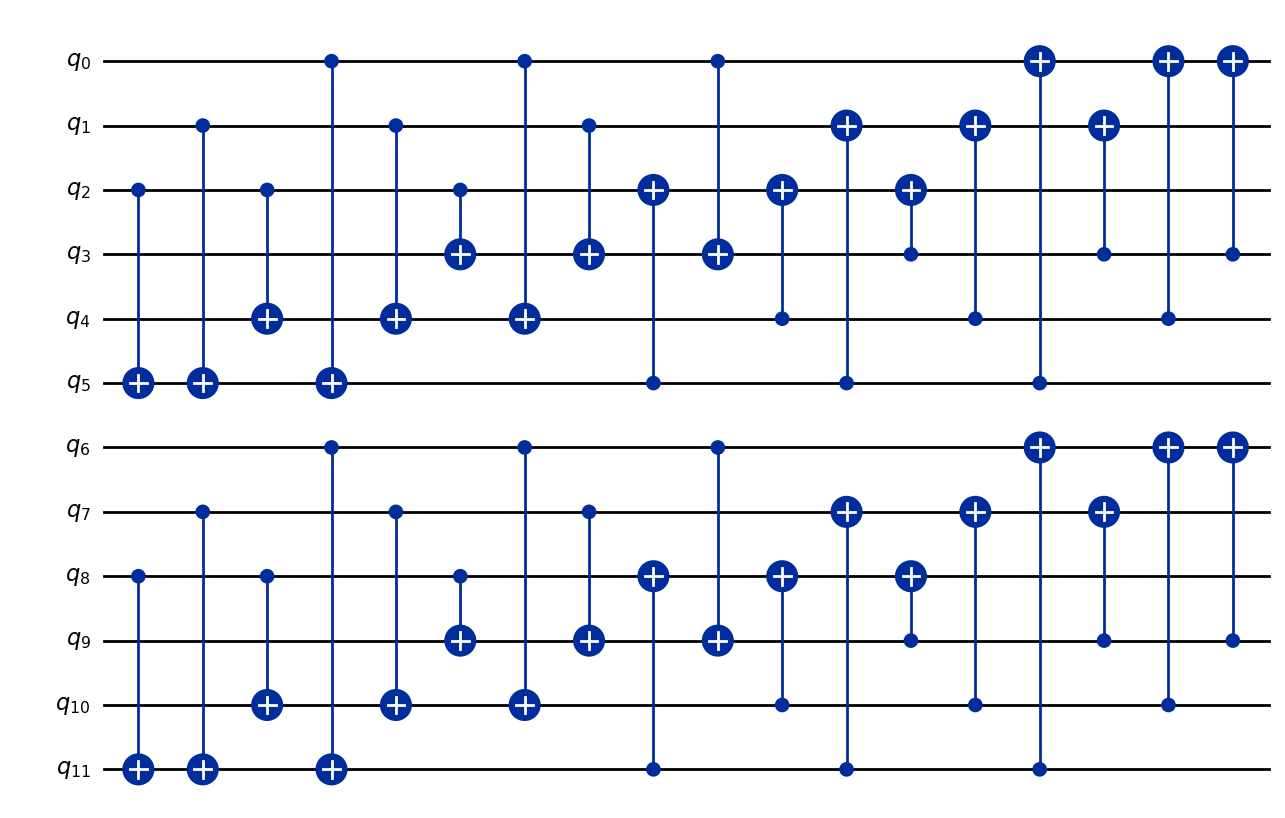

In [15]:
# logical circuit
log_act, phys_circ = circuits[5]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

## Logical action 7

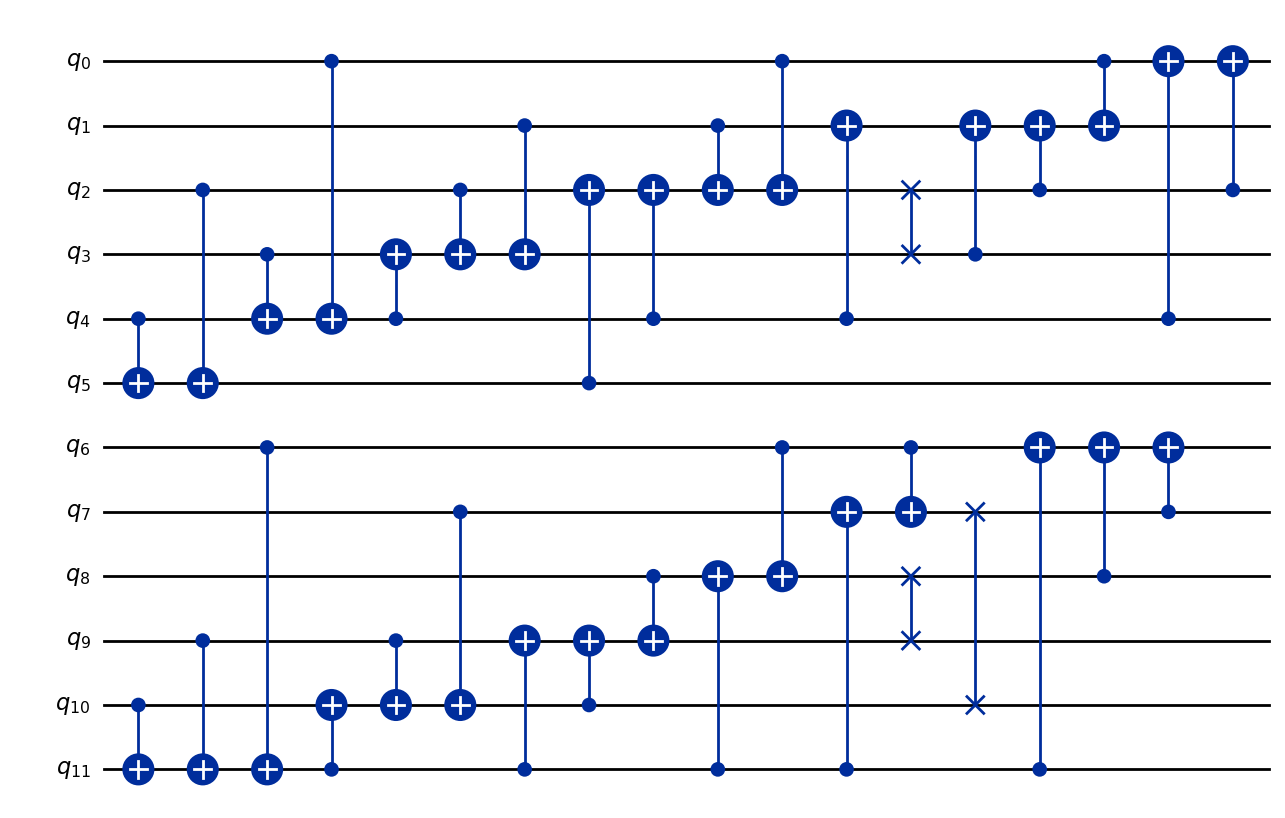

In [16]:
# logical circuit
log_act, phys_circ = circuits[6]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

## Logical gate group structure

In [17]:
filename = f'./symp_mats_n{n}k{k}d{d}.pkl'
with open(filename, 'rb') as f:
    symp_mats = pickle.load(f)

In [18]:
from autqec.logical_subgroups import *
gate_group = clifford_subgroups(k,symp_mats) # uses MAGMA
print(gate_group.return_order())
print(gate_group.return_structure())

864
C2^2.S3^3


## Compare automorphisms with IBM paper

In [19]:
aut_x = np.load(f'./code_data/auts_from_paper/aut_x_n{n}k{k}d{d}.npy')
aut_y = np.load(f'./code_data/auts_from_paper/aut_y_n{n}k{k}d{d}.npy')
zx_dual = np.load(f'./code_data/auts_from_paper/zx_duality_n{n}k{k}d{d}.npy')

In [20]:
commands = ''
listofgens = '['
for i, sympmat in enumerate(symp_mats):
    commands += (convert_to_magma_mat(sympmat,'a'+f'{i}'))
    listofgens += f'a{i},'
listofgens = listofgens[:-1]
listofgens += ']'
commands += f"""
listofgens := {listofgens};
G := GeneralLinearGroup({2*k},GF(2));
listminimal := [];
indices := [];
s := 1;
order_previous := 1; // Order of the trivial subgroup
while s le #listofgens do
    x := listofgens[s];
    Append(~listminimal, x);
    S := sub<G | listminimal>;
    order_current := #S;
    if order_current gt order_previous then
        Append(~indices, s);
        order_previous := order_current;
    else
        Prune(~listminimal); // Remove the last element from listminimal
    end if;
    s := s + 1;
end while;
SG := sub<G | listminimal>;
counter := 1;
command := "FG<";
for i in indices do
    if counter lt #indices then
        command cat:= "a";
        command cat:= IntegerToString(indices[counter]);
        command cat:=",";
        counter := counter+1;
    else
        command cat:="a";
        command cat:= IntegerToString(i);
        command cat:= ">, phi := FPGroup(SG); return FG, phi";
    end if;
end for;
FG, phi := eval command;
{convert_to_magma_mat(aut_x,'aut_x')}
{convert_to_magma_mat(aut_y,'aut_y')}
{convert_to_magma_mat(zx_dual,'zx_dual')}
ibm_autgroup := sub<G | aut_x,aut_y,zx_dual>;

order:=Order(SG);
printf "Order of full aut group: ";
order;
structure:=GroupName(SG);
printf "Structure of full aut group: ";
structure;

order:=Order(ibm_autgroup);
printf "Order of IBM aut group: ";
order;
structure:=GroupName(ibm_autgroup);
printf "Structure of IBM aut group: ";
structure;

extra_gens := SG / ibm_autgroup;
order:=Order(extra_gens);
printf "Order of quotient group: ";
order;
structure:=GroupName(extra_gens);
printf "Structure of quotient group: ";
structure;
"""

In [21]:
print(magma(commands))

Magma V2.28-8     Thu Dec  5 2024 20:14:14 on Hasans-MBP-2 [Seed = 171926557]
Type ? for help.  Type <Ctrl>-D to quit.
Order of full aut group: 864
Structure of full aut group: C2^2.S3^3
Order of IBM aut group: 72
Structure of IBM aut group: C2^2*C3:S3
Order of quotient group: 12
Structure of quotient group: D6

Total time: 0.100 seconds, Total memory usage: 32.09MB

